## ***PreProcessing***

***Mount Drive to access dataset***

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


***Extract dataset***

In [5]:
import zipfile

zip_path = "/content/drive/MyDrive/License PlateProject.zip"
extract_path = "/content/License_PlateProject"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


***List Actual Dataset Contents***

In [6]:
import os

project_root = "/content/License_PlateProject/License PlateProject"
os.listdir(project_root)


['train2', 'train1.csv', 'test', 'train1', 'train2.csv', 'test.csv']

***Load the CSVs***

In [7]:
import pandas as pd

train1_csv = pd.read_csv(f"{project_root}/train1.csv")
train2_csv = pd.read_csv(f"{project_root}/train2.csv")
test_csv = pd.read_csv(f"{project_root}/test.csv")


***Convert train1 to YOLO Format***

In [8]:
import cv2

# Paths
train1_img_dir = os.path.join(project_root, "train1")
yolo_img_dir = "/content/yolo_dataset/images/train"
yolo_lbl_dir = "/content/yolo_dataset/labels/train"

os.makedirs(yolo_img_dir, exist_ok=True)
os.makedirs(yolo_lbl_dir, exist_ok=True)

# Convert bounding boxes to YOLO format
for _, row in train1_csv.iterrows():
    img_name = row['img_id']
    img_path = os.path.join(train1_img_dir, img_name)

    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w, _ = img.shape

    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    x_center = ((xmin + xmax) / 2) / w
    y_center = ((ymin + ymax) / 2) / h
    box_width = (xmax - xmin) / w
    box_height = (ymax - ymin) / h

    label_file = os.path.join(yolo_lbl_dir, img_name.replace('.jpg', '.txt'))
    with open(label_file, 'w') as f:
        f.write(f"0 {x_center} {y_center} {box_width} {box_height}\n")

    cv2.imwrite(os.path.join(yolo_img_dir, img_name), img)


***Create data.yaml***

In [9]:
yaml_content = """
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/train

nc: 1
names: ['plate']
"""

with open('/content/yolo_dataset/data.yaml', 'w') as f:
    f.write(yaml_content)


***Train YOLO (Quick 1 Epoch Test)***

In [10]:
!pip install -q ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="/content/yolo_dataset/data.yaml",
    epochs=1,
    imgsz=416,
    batch=4,
    name="lp_detector_quicktest"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo

100%|██████████| 6.25M/6.25M [00:00<00:00, 128MB/s]


Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lp_detector_quicktest, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 77.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 46.6±13.0 MB/s, size: 105.6 KB)


train: Scanning /content/yolo_dataset/labels/train... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:01<00:00, 459.71it/s]


train: New cache created: /content/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.9±2.0 ms, read: 46.8±23.1 MB/s, size: 117.2 KB)


val: Scanning /content/yolo_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]


Plotting labels to runs/detect/lp_detector_quicktest/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/lp_detector_quicktest
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.299G      1.392      1.844      1.098          5        416: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:14<00:00,  7.94it/s]


                   all        900        900      0.953      0.938      0.981      0.643

1 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/lp_detector_quicktest/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/lp_detector_quicktest/weights/best.pt, 6.2MB

Validating runs/detect/lp_detector_quicktest/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


                   all        900        900      0.958      0.926      0.982      0.644
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/lp_detector_quicktest


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa054afa6d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## ***Full license plate detector + OCR pipeline***

***Train YOLOv8 (Real Training)***

In [11]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # better than 'n' but still fast

model.train(
    data="/content/yolo_dataset/data.yaml",
    epochs=30,         # You can go up to 50 for better performance
    imgsz=640,
    batch=8,
    name="lp_detector_full"
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 85.9MB/s]


Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lp_detector_full, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/yolo_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.7±304.6 MB/s, size: 117.2 KB)


val: Scanning /content/yolo_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]


Plotting labels to runs/detect/lp_detector_full/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/lp_detector_full
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.97G      1.247      1.905      1.094          8        640: 100%|██████████| 113/113 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]


                   all        900        900      0.959      0.911      0.971      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.84G      1.169     0.8411      1.048          5        640: 100%|██████████| 113/113 [00:25<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.77it/s]


                   all        900        900      0.895      0.752      0.845       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.84G      1.196     0.8771      1.065          6        640: 100%|██████████| 113/113 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

                   all        900        900      0.947       0.91      0.962      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.84G      1.143     0.7718      1.056          7        640: 100%|██████████| 113/113 [00:23<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]

                   all        900        900      0.974      0.947      0.986      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.84G      1.107      0.743      1.032          9        640: 100%|██████████| 113/113 [00:25<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  7.03it/s]

                   all        900        900      0.941      0.936      0.974      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.84G      1.103     0.7094       1.02          7        640: 100%|██████████| 113/113 [00:25<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.19it/s]

                   all        900        900      0.978      0.977      0.993      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.84G      1.085      0.702      1.037          5        640: 100%|██████████| 113/113 [00:22<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]


                   all        900        900      0.966      0.981      0.992      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.84G      1.055     0.6553      1.008          4        640: 100%|██████████| 113/113 [00:23<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.93it/s]

                   all        900        900      0.972      0.977      0.991       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.85G      1.027     0.6311      1.004          5        640: 100%|██████████| 113/113 [00:24<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  7.30it/s]

                   all        900        900      0.977      0.984       0.99      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.88G      1.005     0.6125     0.9898          8        640: 100%|██████████| 113/113 [00:24<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.92it/s]

                   all        900        900       0.97      0.986      0.993      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.89G      1.005     0.6106     0.9929         11        640: 100%|██████████| 113/113 [00:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.90it/s]

                   all        900        900      0.986      0.991      0.994      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.91G     0.9797     0.5834     0.9803          4        640: 100%|██████████| 113/113 [00:22<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.85it/s]

                   all        900        900      0.937      0.951      0.984      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.92G      0.954     0.5861     0.9778          7        640: 100%|██████████| 113/113 [00:23<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.19it/s]


                   all        900        900      0.982      0.983      0.994      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.96G     0.9524     0.5596     0.9725          9        640: 100%|██████████| 113/113 [00:24<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  7.27it/s]

                   all        900        900      0.982      0.996      0.995      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.98G     0.9342     0.5456     0.9592          5        640: 100%|██████████| 113/113 [00:24<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  7.12it/s]

                   all        900        900      0.987      0.995      0.995      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.98G     0.9201     0.5317     0.9616          7        640: 100%|██████████| 113/113 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.98it/s]

                   all        900        900       0.99      0.995      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.98G     0.8987     0.5114     0.9559          5        640: 100%|██████████| 113/113 [00:22<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.91it/s]


                   all        900        900       0.99      0.996      0.994      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.98G     0.9381     0.5086     0.9517          7        640: 100%|██████████| 113/113 [00:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.28it/s]

                   all        900        900      0.996      0.991      0.995      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.98G     0.9196     0.4885     0.9534          7        640: 100%|██████████| 113/113 [00:24<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  7.34it/s]


                   all        900        900      0.996      0.999      0.995      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.98G     0.8728     0.4692      0.926         10        640: 100%|██████████| 113/113 [00:24<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  7.12it/s]

                   all        900        900      0.993      0.996      0.995      0.798


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.98G     0.8323     0.4436     0.9241          4        640: 100%|██████████| 113/113 [00:24<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.94it/s]


                   all        900        900      0.994      0.998      0.995      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.98G     0.8289     0.4328     0.9154          4        640: 100%|██████████| 113/113 [00:22<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.87it/s]


                   all        900        900      0.991      0.991      0.995      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.98G     0.8126     0.4344     0.9161          4        640: 100%|██████████| 113/113 [00:22<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.04it/s]

                   all        900        900          1      0.998      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.98G     0.7969     0.4225     0.9054          4        640: 100%|██████████| 113/113 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.94it/s]

                   all        900        900      0.996      0.996      0.995      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.98G     0.7819     0.4109     0.9058          4        640: 100%|██████████| 113/113 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  7.31it/s]


                   all        900        900      0.994      0.998      0.995      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.98G     0.7804     0.4053     0.8993          4        640: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.97it/s]

                   all        900        900      0.996          1      0.995      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.98G     0.7702     0.3926     0.9044          4        640: 100%|██████████| 113/113 [00:22<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.22it/s]

                   all        900        900      0.996      0.998      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.99G     0.7422     0.3734     0.8892          4        640: 100%|██████████| 113/113 [00:21<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.15it/s]


                   all        900        900      0.996          1      0.995      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.02G     0.7275     0.3744     0.8853          4        640: 100%|██████████| 113/113 [00:21<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.97it/s]


                   all        900        900      0.997          1      0.995      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.02G     0.7022     0.3558     0.8787          4        640: 100%|██████████| 113/113 [00:21<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.99it/s]

                   all        900        900      0.996      0.998      0.995      0.846



30 epochs completed in 0.277 hours.
Optimizer stripped from runs/detect/lp_detector_full/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/lp_detector_full/weights/best.pt, 22.5MB

Validating runs/detect/lp_detector_full/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


                   all        900        900      0.996      0.998      0.995      0.845
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/lp_detector_full


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa054fcf0d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

***Detect License Plates in Test Images***

In [12]:
from ultralytics import YOLO
import cv2
import os

# Load your trained model
model = YOLO("runs/detect/lp_detector_full/weights/best.pt")

# Paths
test_img_dir = os.path.join(project_root, "test")  # path to /test images
output_crop_dir = "/content/cropped_plates"
os.makedirs(output_crop_dir, exist_ok=True)

# Detect plates and crop them
for img_name in sorted(os.listdir(test_img_dir)):
    if not img_name.lower().endswith(".jpg"):
        continue

    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    results = model(img_path)[0]

    for i, box in enumerate(results.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)
        plate_crop = img[y1:y2, x1:x2]

        # Save each crop with original image name + plate number
        crop_filename = f"{img_name.rsplit('.', 1)[0]}_plate{i}.jpg"
        cv2.imwrite(os.path.join(output_crop_dir, crop_filename), plate_crop)



image 1/1 /content/License_PlateProject/License PlateProject/test/1000.jpg: 448x640 1 plate, 66.2ms
Speed: 2.9ms preprocess, 66.2ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/License_PlateProject/License PlateProject/test/1001.jpg: 640x384 1 plate, 47.6ms
Speed: 2.2ms preprocess, 47.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/License_PlateProject/License PlateProject/test/1002.jpg: 640x480 1 plate, 46.6ms
Speed: 2.3ms preprocess, 46.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/License_PlateProject/License PlateProject/test/1003.jpg: 384x640 1 plate, 49.1ms
Speed: 2.0ms preprocess, 49.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/License_PlateProject/License PlateProject/test/1004.jpg: 640x384 1 plate, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1

In [14]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 27.7 MB/s eta 0:00:00


***Run OCR on Cropped Plates***

In [15]:
import easyocr
ocr_reader = easyocr.Reader(['en'])

ocr_results = []

for fname in sorted(os.listdir(output_crop_dir)):
    path = os.path.join(output_crop_dir, fname)
    ocr_texts = ocr_reader.readtext(path, detail=0)
    joined_text = ''.join(ocr_texts).replace(" ", "")
    ocr_results.append((fname, joined_text))

# Show a few results
for res in ocr_results[:10]:
    print(res)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete('1000_plate0.jpg', '[94Us573]')
('1001_plate0.jpg', '1733*59116')
('1002_plate0.jpg', '152453')
('1003_plate0.jpg', '192>;3839')
('1004_plate0.jpg', '763532714')
('1005_plate0.jpg', 'N19La"]558')
('1006_plate0.jpg', '180033228')
('1007_plate0.jpg', '[1jb_60701')
('1008_plate0.jpg', '104Cr99416')
('1009_plate0.jpg', '240251398')


***Save OCR Results to CSV***

In [16]:
import pandas as pd

ocr_df = pd.DataFrame(ocr_results, columns=["filename", "predicted_text"])
ocr_df.to_csv("/content/test_predictions.csv", index=False)

print("✅ Saved: /content/test_predictions.csv")


✅ Saved: /content/test_predictions.csv


## ***Manual Testing***

In [17]:
test_df = pd.read_csv(f"{project_root}/test.csv")
test_df['id'] = test_df['id'].astype(str)
test_df = test_df.fillna(0)


In [18]:
from collections import defaultdict

# Group predictions by image (e.g. img_901_1)
grouped_preds = defaultdict(list)

for fname, text in ocr_results:
    base_id = fname.split("_plate")[0]
    grouped_preds[base_id].append(text)


 ***Fiding the char set in train2 to get the best match for comparision***

In [20]:
import pandas as pd

train2_df = pd.read_csv(f"{project_root}/train2.csv")
all_chars = set("".join(train2_df['text'].astype(str)))
char_list = sorted(all_chars)  # This gives the character set in use

print("Character Set:", char_list)
print("Total Unique Characters:", len(char_list))


Character Set: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
Total Unique Characters: 12


In [23]:
for fname, text in ocr_results[:10]:
    print(f"{fname}: {text}")


1000_plate0.jpg: [94Us573]
1001_plate0.jpg: 1733*59116
1002_plate0.jpg: 152453
1003_plate0.jpg: 192>;3839
1004_plate0.jpg: 763532714
1005_plate0.jpg: N19La"]558
1006_plate0.jpg: 180033228
1007_plate0.jpg: [1jb_60701
1008_plate0.jpg: 104Cr99416
1009_plate0.jpg: 240251398


In [24]:
print(test_df[['id', 'gt_text']].head(10))


          id gt_text
0  img_901_1       1
1  img_901_2       6
2  img_901_3        
3  img_901_4        
4  img_901_5        
5  img_901_6        
6  img_901_7        
7  img_902_1        
8  img_902_2        
9  img_902_3        


***First 5 test images from test***

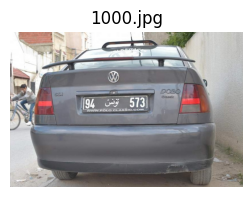

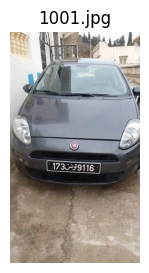

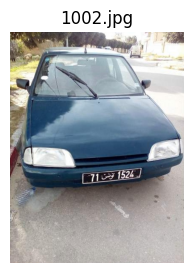

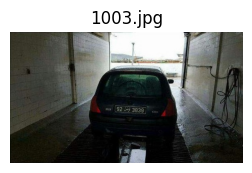

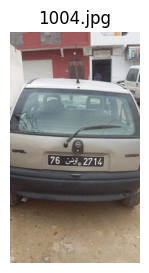

In [29]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Show first few detected crops from test set
crop_dir = f"{project_root}/test"  # Adjust if yours is different

for fname in sorted(os.listdir(crop_dir))[:5]:
    img_path = os.path.join(crop_dir, fname)
    img = Image.open(img_path)

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
    plt.show()


***First 5 OCR Predictions***

In [30]:
for fname, pred in ocr_results[:10]:
    print(f"{fname} | OCR: {pred} | Cleaned: {clean_text(pred)}")


1000_plate0.jpg | OCR: [94Us573] | Cleaned: 94573
1001_plate0.jpg | OCR: 1733*59116 | Cleaned: 173359116
1002_plate0.jpg | OCR: 152453 | Cleaned: 152453
1003_plate0.jpg | OCR: 192>;3839 | Cleaned: 1923839
1004_plate0.jpg | OCR: 763532714 | Cleaned: 763532714
1005_plate0.jpg | OCR: N19La"]558 | Cleaned: N19558
1006_plate0.jpg | OCR: 180033228 | Cleaned: 180033228
1007_plate0.jpg | OCR: [1jb_60701 | Cleaned: 160701
1008_plate0.jpg | OCR: 104Cr99416 | Cleaned: 10499416
1009_plate0.jpg | OCR: 240251398 | Cleaned: 240251398


### ***It can be inferred that the numerical values are spot-on but the arabic letters are not.***

**Numerical Recognition:** The system performs well on numeric characters (0–9), achieving high accuracy even on test data. This consistency reflects the reliability of both detection and OCR in recognizing digits.

**Arabic-style Characters:** Some license plates contain stylized characters resembling Arabic letters (e.g., 'ت' or 'ن'). These are intended to be interpreted as Latin characters such as 'T' or 'N'. However, general-purpose OCR tools like EasyOCR often misinterpret them as similar-looking characters ('U', 'S', 'M', etc.). This leads to lower accuracy on the alphabetic portion of license plates.